# Analysis and visualization of spatial transcriptomics data

In [ ]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sc.logging.print_versions()
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.settings.verbosity = 3

-----
anndata     0.8.0
scanpy      1.7.2
-----
PIL                         8.0.1
asttokens                   NA
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
bottleneck                  1.3.5
cloudpickle                 1.6.0
colorama                    0.4.6
comm                        0.1.2
cycler                      0.10.0
cython_runtime              NA
cytoolz                     0.11.0
dask                        1.0.0
dateutil                    2.8.2
debugpy                     1.5.1
decorator                   5.1.1
entrypoints                 0.4
executing                   0.8.3
h5py                        3.7.0
hypergeom_ufunc             NA
igraph                      0.8.3
importlib_resources         NA
ipykernel                   6.19.2
jedi                        0.18.1
joblib                      1.2.0
kiwisolver                  1.3.1
leidenalg                   0.8.3
llvmlite                    0.34.0
matplotlib     

## Reading the data

We will use a Visium spatial transcriptomics dataset of the human lymphnode, which is publicly available from the 10x genomics website: [link](https://support.10xgenomics.com/spatial-gene-expression/datasets/1.0.0/V1_Human_Lymph_Node).

The function [datasets.visium_sge()](https://scanpy.readthedocs.io/en/latest/api/scanpy.datasets.visium_sge.html) downloads the dataset from 10x Genomics and returns an `AnnData` object that contains counts, images and spatial coordinates. We will calculate standards QC metrics with [pp.calculate_qc_metrics](https://scanpy.readthedocs.io/en/latest/api/scanpy.pp.calculate_qc_metrics.html) and percentage of mitochondrial read counts per sample.

When using your own Visium data, use [sc.read_visium()](https://scanpy.readthedocs.io/en/latest/api/scanpy.read_visium.html) function to import it.

In [3]:
adata = sc.datasets.visium_sge(sample_id="V1_Human_Lymph_Node")
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

100%|██████████| 7.86M/7.86M [00:00<00:00, 9.46MB/s]
100%|██████████| 29.3M/29.3M [00:00<00:00, 81.1MB/s]

reading /data/scratch/fotakis/spatial/10X/Visium/env/data/V1_Human_Lymph_Node/filtered_feature_bc_matrix.h5


 (0:00:01)


/home/fotakis/.conda/envs/atlas_protocol/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/fotakis/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 6103. The TBB threading layer is disabled.
  warnings.warn(problem)


## QC and preprocessing

<Axes: xlabel='n_genes_by_counts', ylabel='Count'>

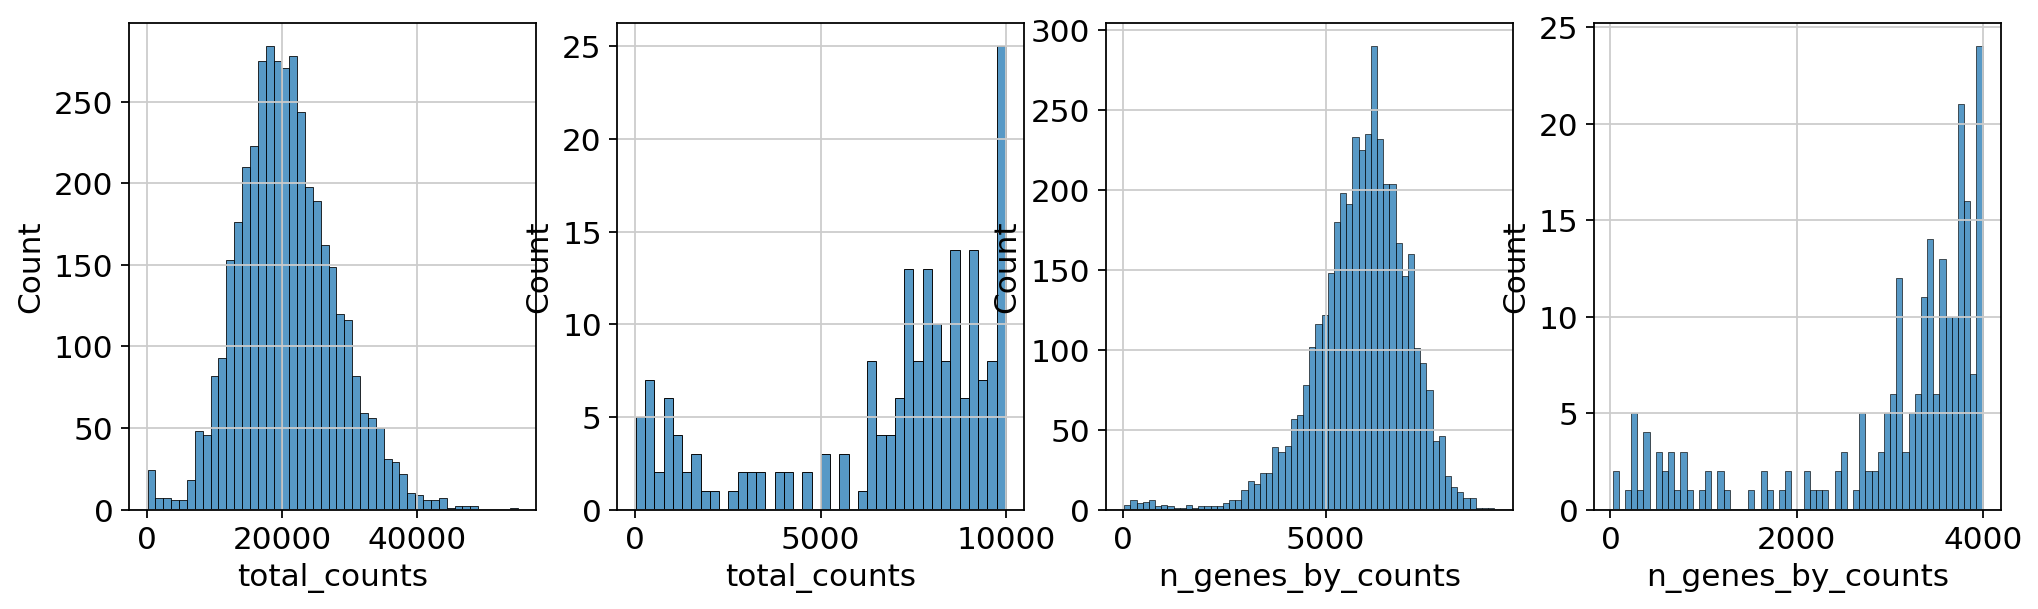

In [4]:
fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.histplot(adata.obs["total_counts"], kde=False, ax=axs[0])
sns.histplot(
    adata.obs["total_counts"][adata.obs["total_counts"] < 10000],
    kde=False,
    bins=40,
    ax=axs[1],
)
sns.histplot(adata.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.histplot(
    adata.obs["n_genes_by_counts"][adata.obs["n_genes_by_counts"] < 4000],
    kde=False,
    bins=60,
    ax=axs[3],
)

In [5]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20].copy()
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)

filtered out 44 cells that have less than 5000 counts
filtered out 130 cells that have more than 35000 counts
#cells after MT filter: 3861
filtered out 16916 genes that are detected in less than 10 cells


We proceed to normalize Visium counts data with the built-in `normalize_total` method from Scanpy, and detect highly-variable genes (for later). Note that there are alternatives for normalization (see discussion in [[Luecken19](https://www.embopress.org/doi/full/10.15252/msb.20188746)], and more recent alternatives such as [SCTransform](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1) or [GLM-PCA](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1861-6)).


In [6]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

normalizing counts per cell
    finished (0:00:00)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


## Manifold embedding and clustering based on transcriptional similarity

In [8]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(
    adata, key_added="clusters", directed=False, n_iterations=2
)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)
running Leiden clustering
    finished: found 10 clusters and added
    'clusters', the cluster labels (adata.obs, categorical) (0:00:00)


We plot some covariates to check if there is any particular structure in the UMAP associated with total counts and detected genes.


/home/fotakis/.conda/envs/atlas_protocol/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


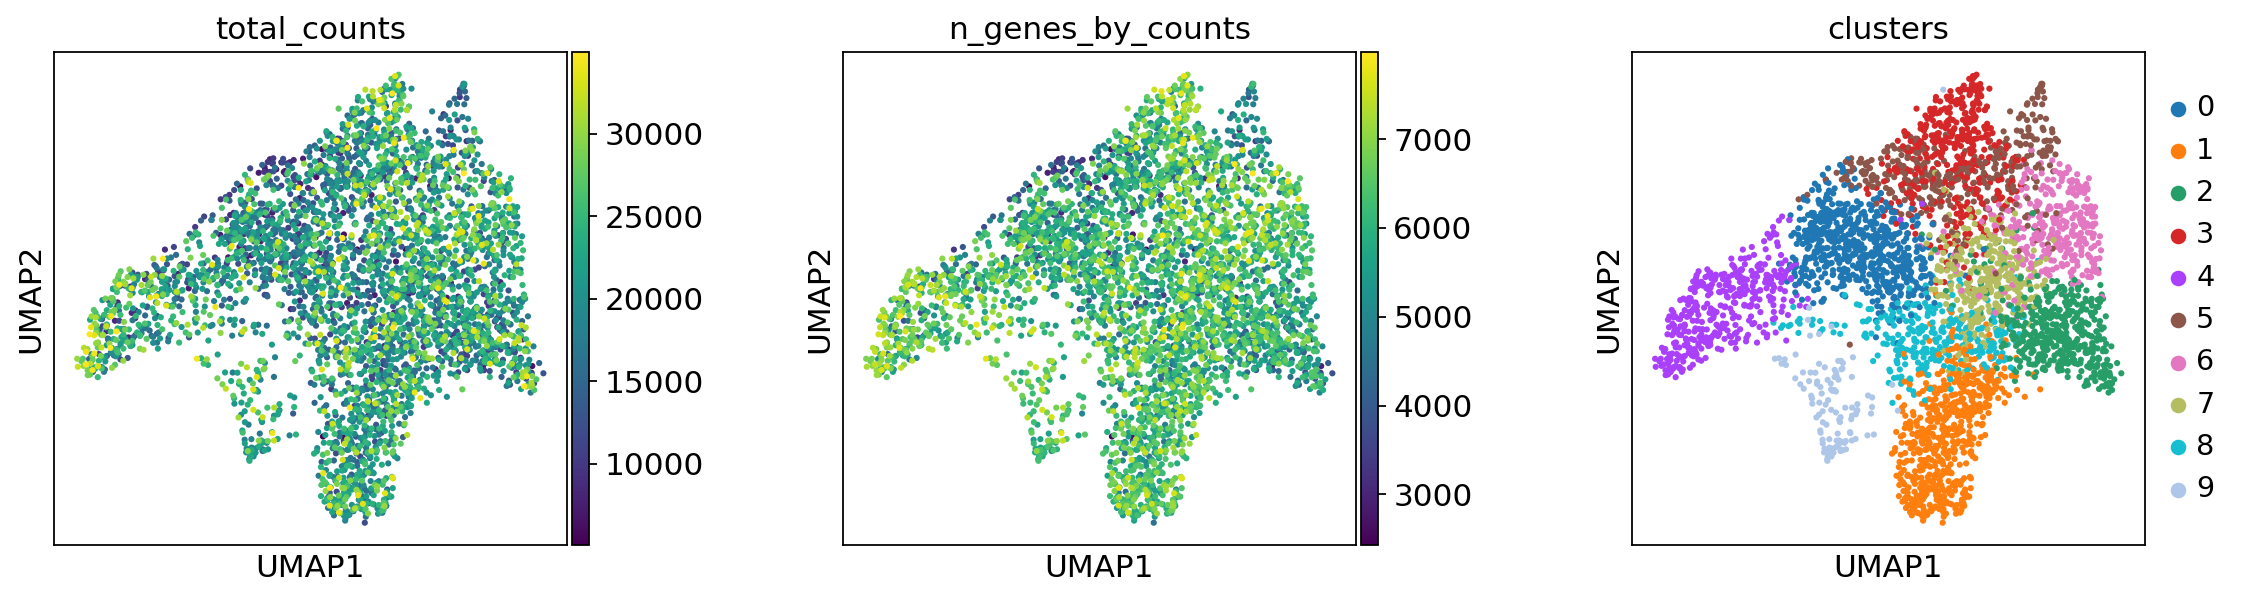

In [9]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

## Visualization in spatial coordinates

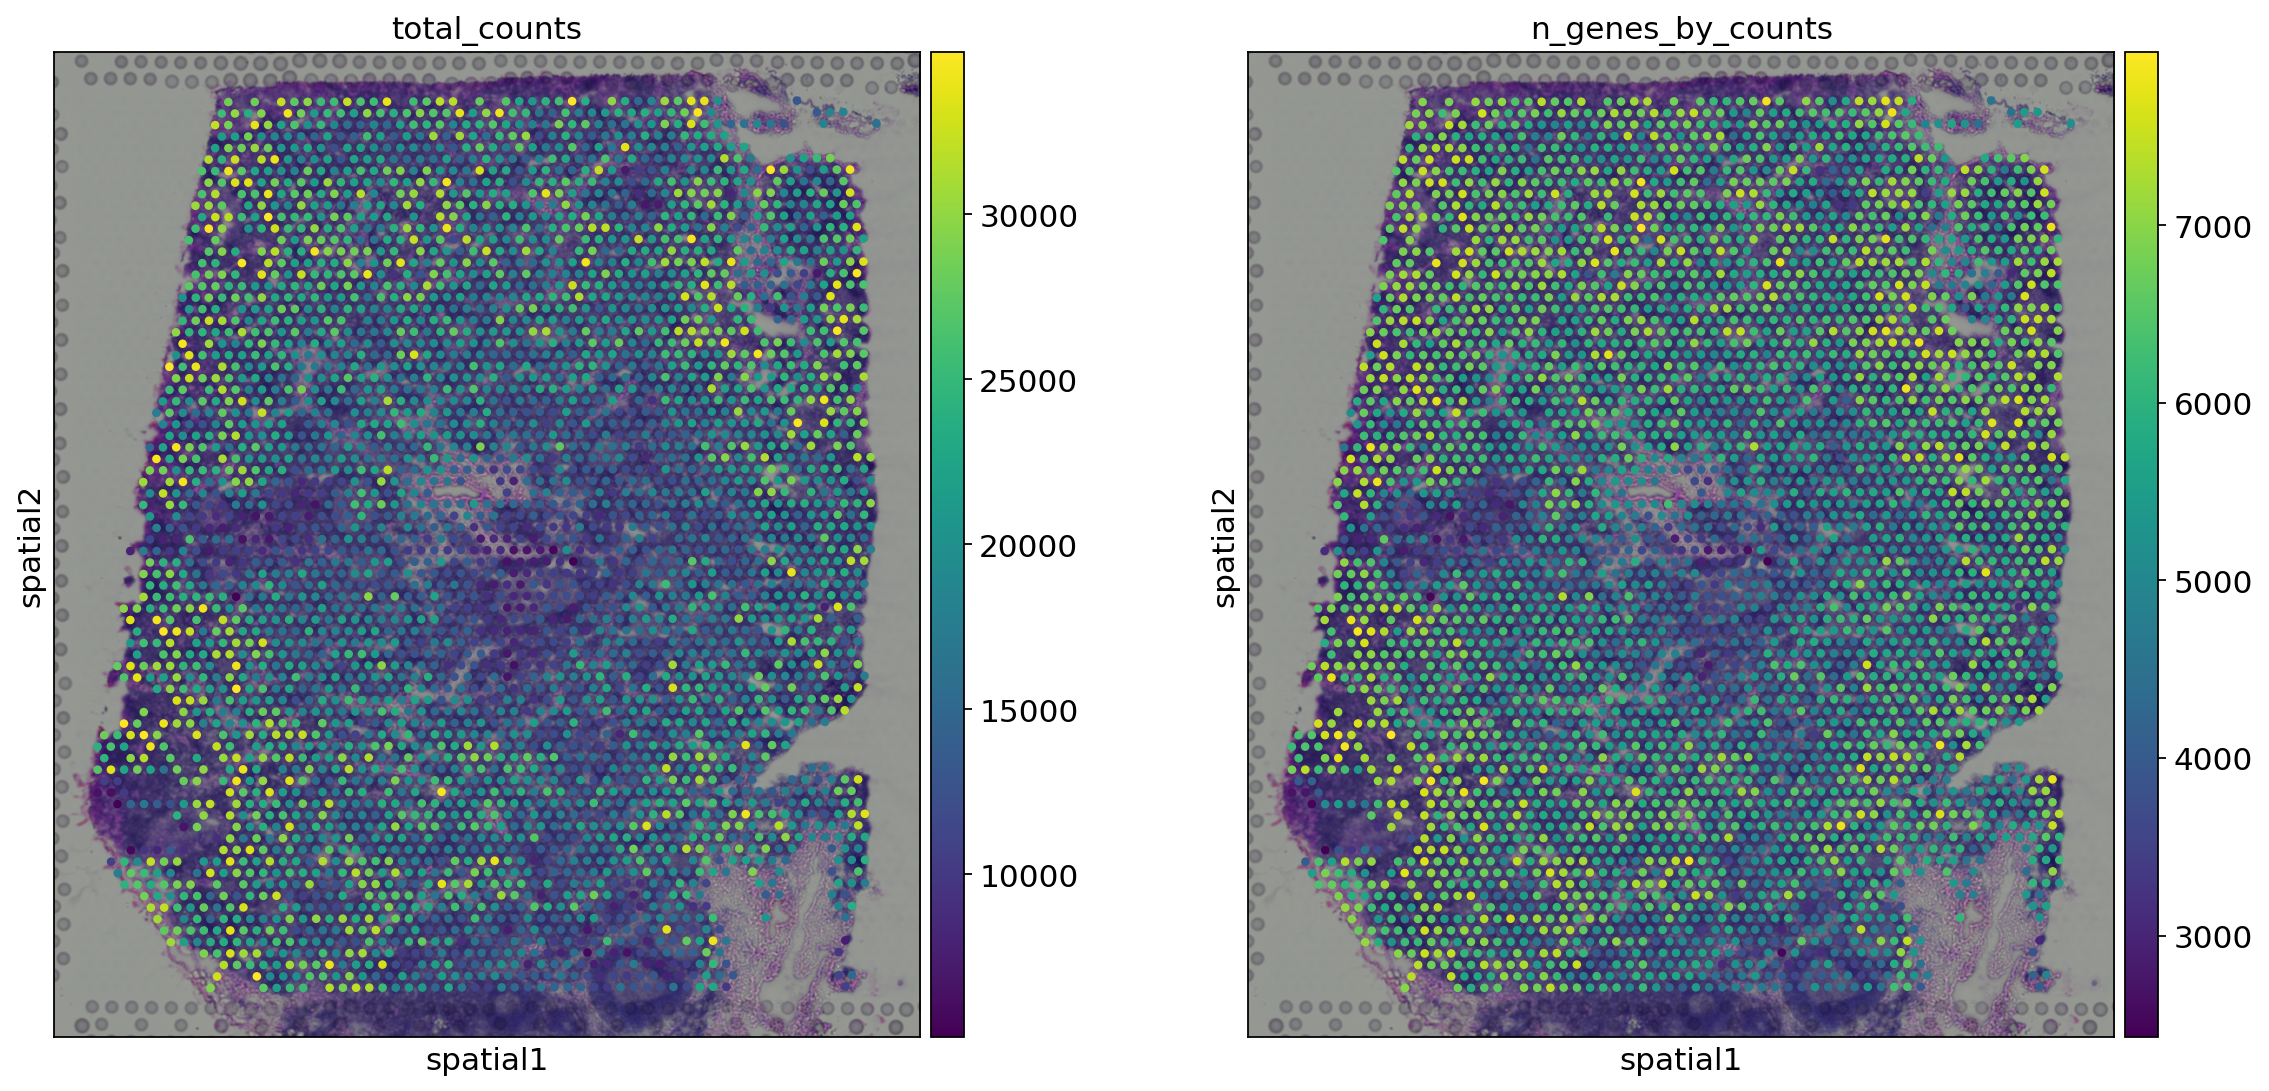

In [10]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

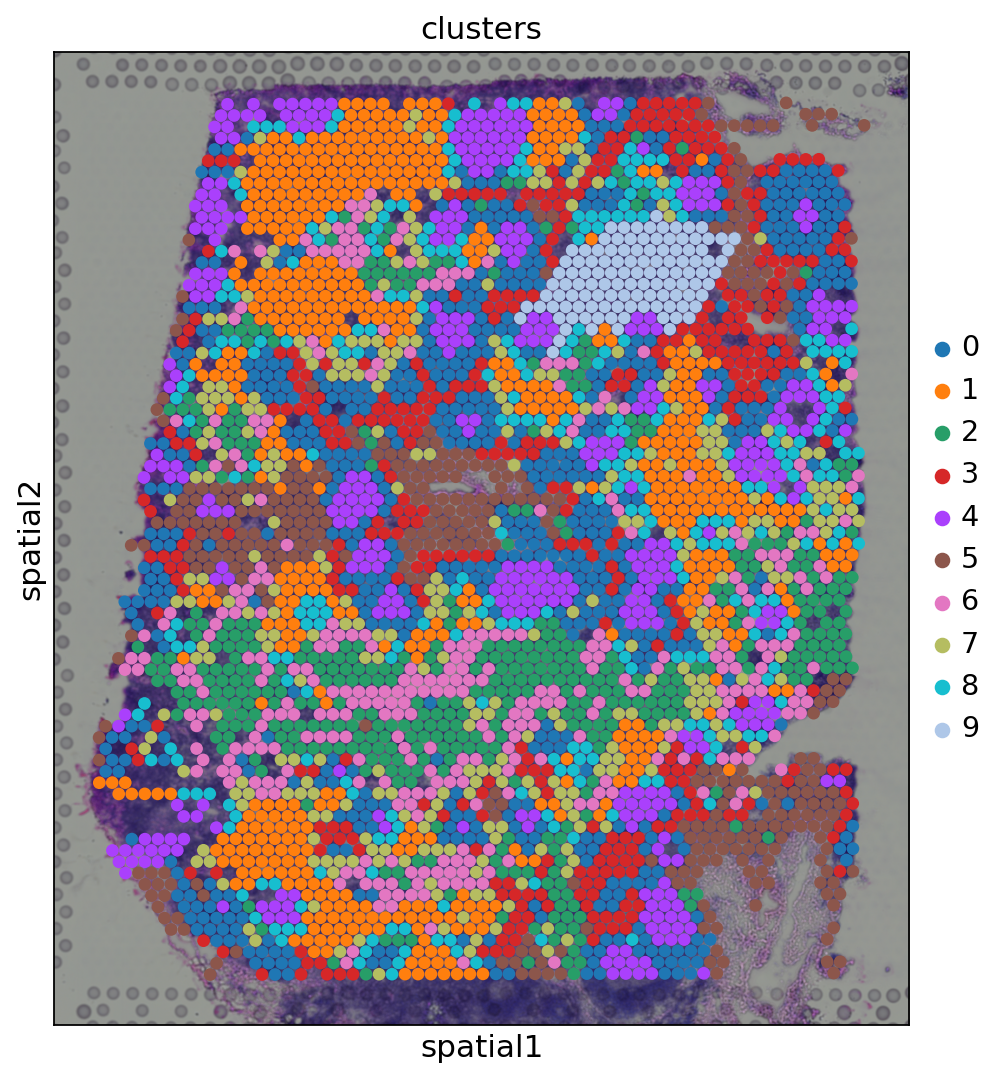

In [11]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1.5)

zoom in specific regions of interests to gain qualitative insights

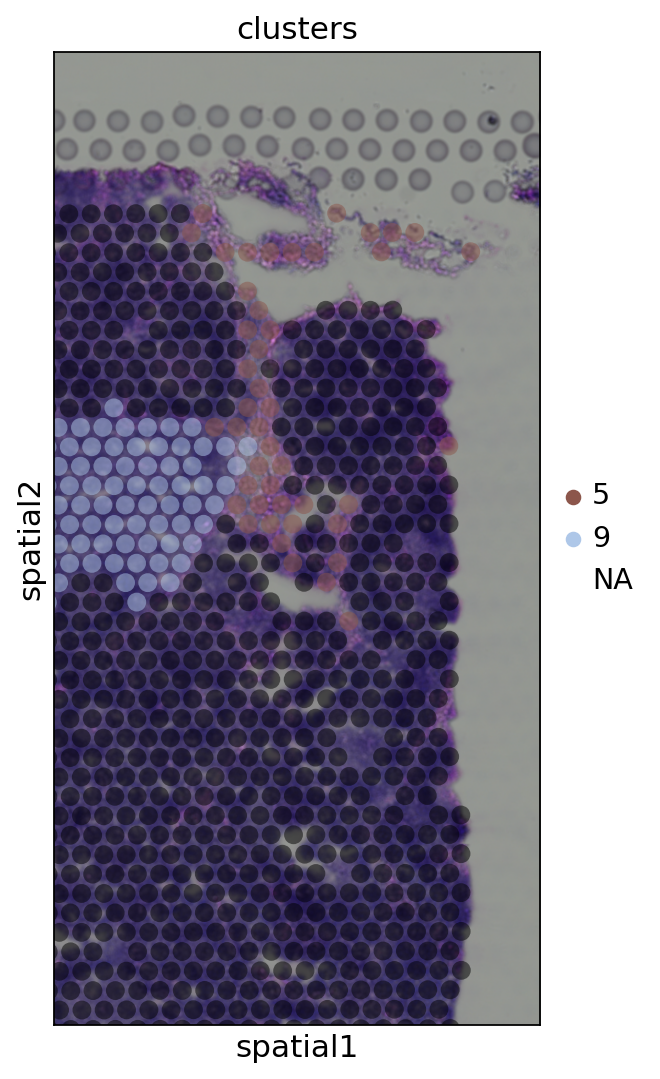

In [12]:
sc.pl.spatial(
    adata,
    img_key="hires",
    color="clusters",
    groups=["5", "9"],
    crop_coord=[7000, 10000, 0, 6000],
    alpha=0.5,
    size=1.3,
)